In [260]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.gridspec as gridspec
import time
import pandas
import scipy.stats as st
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize

Leemos los datos de las supernovas

In [103]:
file = pandas.read_csv("supernovaData.csv")
sigma = np.mean(file['sigma'])
len(file['sigma'])
data = [file['redshift'],file['modDist']]

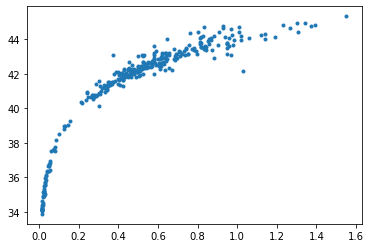

In [26]:
plt.plot(file['redshift'],file['modDist'],'.')

In [122]:
L = 1. #Range of x-data
M = 100 # Number of data points
x = file['redshift']


In [230]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''
    lp = 0.
    # unpack the model parameters from the tuple
    d = theta
    dmin = 0. # lower range of prior
    dmax = .9  # upper range of prior
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if dmin < d < dmax else -np.inf
    
    return lp

In [231]:
def model(x,olambda):
    cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda)
    x = x[0]
    DL = cosmo.luminosity_distance(x) 
    print('olambda',olambda)
    distanceModulus = 5 * np.log10(DL.value)+25
    return distanceModulus

In [249]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''
    # unpack the model parameters
    
    d = theta
    
    # evaluate the model
    lin_md = model(x,d)
    # return the log likelihood
    return -0.5 * np.sum(((lin_md - data[1])/sigma)**2)


In [237]:
def logpost(theta, data, sigma, x):
    return (logprior(theta) + loglike(theta, data, sigma, x))

In [234]:
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 5000 # Number of steps/iterations.
start = np.random.randn(nwalkers,2) # Initial positions of the walkers.
t0 = time.time()
samples = np.random.randn(len(x),2)


In [252]:
def guassian_proposal(theta_curr):
    # proposal based on Gaussian
    theta_new = 0.5*np.abs(st.norm(loc=theta_curr, scale=0.2).rvs())
    return theta_new

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q = 0.5*np.abs(st.norm(loc=x1, scale=1).pdf(x2))
    return q

def mcmc_mh_posterior(X, theta_init,sigma,x,nwalkers,func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    chains = []
    for j in range(nwalkers):
        thetas = []
        
        theta_curr = theta_init[j]
        print('theta_curr',theta_curr)
        accept_rates = []
        accept_cum = 0
        
        for i in range(1, n_iter+1):
            print(i)
            theta_new = proposal_func(theta_curr)

            prob_curr = func(theta_curr,X,sigma,x)
            
            prob_new = func(theta_new,X,sigma,x)
            if prob_new > prob_curr:
                acceptance_ratio = 1
            else:
                qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
                
                acceptance_ratio = np.exp(prob_new - prob_curr) * qr
            acceptance_prob = min(1, acceptance_ratio)
            
            if acceptance_prob > st.uniform(0,1).rvs():
                theta_curr = theta_new
                accept_cum = accept_cum+1
                thetas.append(theta_new)
            else:
                thetas.append(theta_curr)
                
            accept_rates.append(accept_cum/i)
        chains.append(thetas)
        
    return chains, accept_rates


# generate observed data
X = data
nwalkers = 10
initSamples= []
for i in range(nwalkers): initSamples.append(np.random.random())
print(initSamples)
# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, initSamples,sigma,x, nwalkers,
                                         logpost, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=100)


[0.567192733449611, 0.25855878202864846, 0.36170995458010347, 0.5335849343986259, 0.006778176218386056, 0.6530231532253398, 0.013162446300341801, 0.406260428376929, 0.20958901031148858, 0.3003083694979971]
theta_curr 0.567192733449611
1
olambda 0.567192733449611
olambda 0.4662061217376279
2
olambda 0.567192733449611
olambda 0.2137838523851699
3
olambda 0.567192733449611
olambda 0.2946674985546552
4
olambda 0.567192733449611
olambda 0.19421555913892874
5
olambda 0.567192733449611
olambda 0.1951323656563862
6
olambda 0.567192733449611
olambda 0.2599856439199722
7
olambda 0.567192733449611
olambda 0.2906185534758863
8
olambda 0.567192733449611
olambda 0.24010293686362377
9
olambda 0.567192733449611
olambda 0.2834103978613566
10
olambda 0.567192733449611
olambda 0.3078676490914714
11
olambda 0.567192733449611
olambda 0.23961415651722495
12
olambda 0.567192733449611
olambda 0.31682242591787574
13
olambda 0.567192733449611
olambda 0.2703740018805046
14
olambda 0.567192733449611
olambda 0.265

In [253]:
m_theta = []
c_theta = []
chains = []
for i in range(nwalkers):
    d_theta = []
    for j in range(len(thetas[0])):
        d_theta.append(thetas[i][j])
    chains.append(d_theta) 

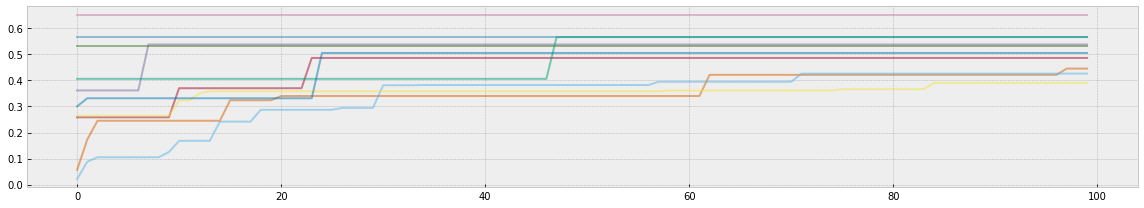

In [254]:


plt.figure(figsize=(16,3))

for i in range(nwalkers):
    plt.plot(chains[i][:], '-',alpha=0.5)
plt.tight_layout()
plt.show()

In [255]:
import seaborn as sns
import pandas
dp = []
for i in range(len(chains[0])):
    meanD = []
    for j in range(nwalkers):
        meanD.append(chains[j][i])
    dp.append(np.mean(meanD))
dp_fit = max(dp)
print(dp_fit)

d = {'c': dp}
c_fit = max(d['c']) 
chainData = pandas.DataFrame(d)
print(chainData)


0.5113728822136729
           c
0   0.342208
1   0.363702
2   0.372614
3   0.372614
4   0.372614
..       ...
95  0.508971
96  0.508971
97  0.511373
98  0.511373
99  0.511373

[100 rows x 1 columns]


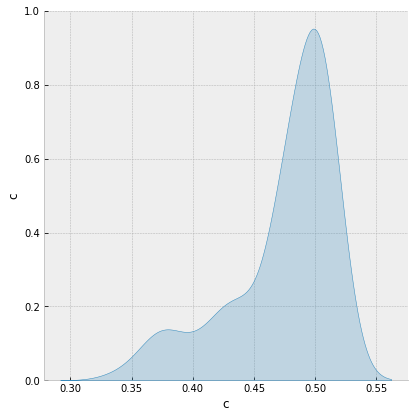

In [350]:
#sns.pairplot(chainData, kind="kde")
plt.style.use('bmh')
g=sns.pairplot(chainData, kind='kde')
g.fig.set_size_inches(7,7)
plt.show()


In [259]:

olambda = 0.5
z=np.linspace(0.01,2,100)
cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda)
DL = cosmo.luminosity_distance(z) 
mu = 5 * np.log10(DL.value)+25

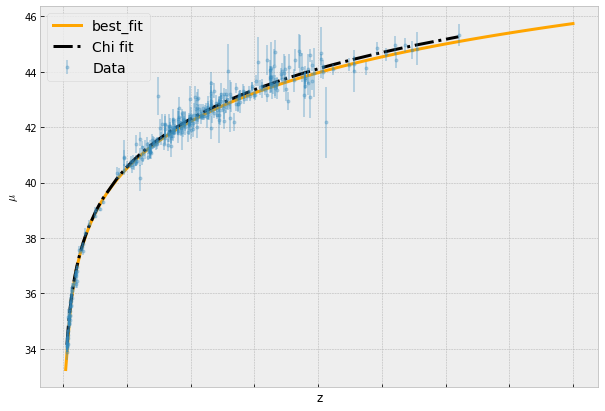

In [343]:
###
fig,ax1=plt.subplots(1,1,figsize=(10,7))
gs=gridspec.GridSpec(1,1)
colors=['b','orange']
###
ax1=plt.subplot(gs[0])


ax1.plot(z,mu, '-',color='orange', lw=3, label='best_fit')
ax1.plot(muChi[0],muChi[1], '-.',color='black', lw=3, label='Chi fit')
ax1.errorbar(file['redshift'],file['modDist'],yerr=file['sigma'].to_numpy(),fmt='.',alpha=0.3,label='Data')
###

ax1.legend(fontsize=14)
models = ['linear model', 'quadratic model']
ax1.set_ylabel('$\mu$')
ax1.set_xlabel(r'z')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)